(tess)=

# Fitting TESS data

In [816]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [817]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    ID_table = Simbad.query_objectids(other_id)
    if ID_table == None:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]

In [818]:
def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    import pandas as pd


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    exoplanets = a.to_table()
    exoplanets = exoplanets.to_pandas()
    
    #rename columns
    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    
    exoplanets.rename(columns=column_dict, inplace=True)
    
    result = exoplanets[exoplanets['tic_id'] == tic_id]

    
    #if there's no row in the planetary comparison table, check TOI table
    if result.empty:
        print("Exoplanet Archive: TOI Table")
        print("----------------------------")
        print("")
        a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

        exoplanets = pd.read_csv(a)
        
        #rename columns
        column_dict = {
        'tid':'tic_id',
        'pl_tranmid':'t0 [BJD]',
        'pl_orbper':'period [days]',
        'pl_trandurh':'duration [hours]',
        }
        
        exoplanets.rename(columns=column_dict, inplace=True)
        exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
        
        result = exoplanets[exoplanets['tic_id'] == tic_id]
        
        
    else:
        print("Exoplanet Archive: Planet Comparison Table")
        print("------------------------------------------")
        print("")
        
    

    return result
    
    



In [819]:
print(transit_info_from_exoplanet_archive(tic_id_from_simbad('tic50365310')))

Exoplanet Archive: TOI Table
----------------------------

          tic_id      t0 [BJD]  period [days]  duration [hours]
70  TIC 50365310  2.459230e+06       2.171348           2.01722


In [820]:
def get_transit_info(planet_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(planet_id)
    if tic_id != None:
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive")
            return None
        
        else:
            return transit_info
            
    else:
        print("No TIC ID match found on Simbad")
        return None

In [821]:
get_transit_info('kepler 1513')

Exoplanet Archive: Planet Comparison Table
------------------------------------------



,tic_id,t0 [BJD],period [days],duration [hours]
916,TIC 394177315,2.455111e+06,160.884651,10.7536


In [822]:
def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [823]:
def get_light_curve(planet_id, flux_type, TESS = False, Kepler = False):
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    periods = np.array(transit_info['period [days]'].values, dtype = float)
    t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)
    durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    

    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    



    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], duration=durations[ii]/24.*1.2, transit_time=t0s[ii])
        mask += masks
    

    lc_transit = lc[mask]
    
    xs_transit = lc_transit.time.value
    ys_transit = lc_transit.flux
    ys_err_transit = lc_transit.flux_err
    
    
    
    lc_star = lc[~mask]
    
    xs_star = lc_star.time.value
    ys_star = lc_star.flux
    ys_err_star = lc_star.flux_err

    min_time = xs.min()
    max_time = xs.max()

    
    t0s_all = []
    for ii in range(0, nplanets):
        t0 = t0s[0]
        period = periods[0]
        while t0 > min_time:
            t0 -= period

        
        while t0 < max_time:
            t0s_all.append(t0)
            t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.mean( ys_star )
    ys_transit = ( ys_transit / mu - 1 )
    ys_star = ( ys_star / mu - 1 )
    ys_err_transit = ( ys_err_transit / mu )
    ys_err_star = ( ys_err_star / mu )
            
    
    
    

    
    return \
        np.array(xs_star), np.array(ys_star), np.array(ys_err_star), \
        np.array(xs_transit), np.array(ys_transit), np.array(ys_err_transit), \
        np.array(t0s_in_data), periods, durations, mask
    
    



In [824]:
def moving_median(time, flux, flux_err, mask, time_window, sigma_window):
    '''
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    mask = array of mask values
    time_window = int, how many data points (in time space) around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_no_outliers = array of flux error values without outliers defined by moving median removed
        mask_no_outliers = array of mask values without outliers defined by moving median removed
        time = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
    
    time_no_outliers = []
    flux_no_outliers = []
    flux_err_no_outliers = []
    mask_no_outliers = []
    
    moving_median = []
    
    time_outliers = []
    flux_outliers = []
    flux_err_outliers = []
    data = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]
        current_mask = mask[ii]
        
        indices = np.where(np.logical_and(time>=current_time-time_window, time<=current_time+time_window))[0]
        current_flux_median = np.median(flux[indices])
        moving_median.append(current_flux_median)
        


        if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
            time_no_outliers.append(current_time)
            flux_no_outliers.append(current_flux)
            flux_err_no_outliers.append(current_flux_err)
            mask_no_outliers.append(current_mask)
            
        else:
            time_outliers.append(current_time)
            flux_outliers.append(current_flux)
            flux_err_outliers.append(current_flux_err)
            
    percent_outliers = np.round(100*(len(time_outliers) / (len(time_outliers)+len(time_no_outliers))),2)
    
    
    time_no_outliers = np.array(time_no_outliers)
    flux_no_outliers = np.array(flux_no_outliers)
    flux_err_no_outliers = np.array(flux_err_no_outliers)
    mask_no_outliers = np.array(mask_no_outliers)
        
    time_outliers = np.array(time_outliers)
    flux_outliers = np.array(flux_outliers)
    flux_err_outliers = np.array(flux_err_outliers)
    
    moving_median = np.array(moving_median)
    
    order = np.argsort(time_no_outliers)
    time_no_outliers = time_no_outliers[order]
    flux_no_outliers = flux_no_outliers[order]
    flux_err_no_outliers = flux_err_no_outliers[order]
    mask_no_outliers = mask_no_outliers[order]
    
    order = np.argsort(time)
    time = time[order]
    moving_median = moving_median[order]
    
    order = np.argsort(time_outliers)
    time_outliers = time_outliers[order]
    flux_outliers = flux_outliers[order]
    flux_err_outliers = flux_err_outliers[order]
    
    
    data = [time_no_outliers, flux_no_outliers, flux_err_no_outliers, mask_no_outliers, time, moving_median, time_outliers, flux_outliers, flux_err_outliers, percent_outliers]

    return data

        

In [825]:
def plot_outliers(moving_median_data):
    '''
    input:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_err_no_outliers = array of flux error values without outliers defined by moving median removed
        mask_no_outliers = array of mask values without outliers defined by moving median removed
        time_all = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    [time_no_outliers, flux_no_outliers, flux_err_no_outliers, mask_no_outliers, \
    time_all, moving_median, \
    time_outliers, flux_outliers, flux_err_outliers, 
    percent_outliers] = moving_median_data
    

    
    fig, ax = plt.subplots(1, 1, figsize = [18,6])
    ax.plot(time_no_outliers, flux_no_outliers, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(time_outliers, flux_outliers, '.', color = '#ca3d7a', alpha = 0.5)
    ax.plot(time_all, moving_med, color = 'black', linestyle = 'dotted')
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [826]:
def plot_individual_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, xlim, period):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    #period = planet period to define plotting limit
    
    fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [6,3*len(t0s_in_data)])
    if len(t0s_in_data) > 1:
        for ii in range(0, len(t0s_in_data)):
            t0 = t0s_in_data[ii]
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(t0-(period/xlim), t0+(period/xlim))
        
    else:
        t0 = t0s_in_data[0]
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period/xlim), t0+(period/xlim))
        
    fig.tight_layout()
    fig.show()
    
    return None

In [827]:
def plot_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxes in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(1, 1, figsize = [18,6])
    ax.plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
    [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [984]:
def plot_phase_fold_lc(time, lc, period, t0s, xlim):
    
    plt.figure(figsize = [18,6])
    x_fold = (
        time - t0s[0] + 0.5 * period
    ) % period - 0.5 * period
    plt.scatter(x_fold, lc, c=time, s=10)
    plt.xlabel("time since transit [days]")
    plt.ylabel("intensity [ppm]")
    plt.colorbar(label="time [days]")
    _ = plt.xlim(0.-(period/xlim), 0.+(period/xlim))

In [829]:
def recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star):
   
    time_all = np.concatenate((time_transit, time_star))
    lc_all = np.concatenate((lc_transit, lc_star))
    lc_err_all = np.concatenate((lc_err_transit, lc_err_star))
    
    order = np.argsort(time_all)
    time_all = time_all[order]
    lc_all = lc_all[order]
    lc_err_all = lc_err_all[order]
    
    return(time_all, lc_all, lc_err_all)
    
    

In [993]:
#kepler 1513 = koi-3678
time_star, lc_star, lc_err_star, \
time_transit, lc_transit, lc_err_transit, \
t0s, period, duration, mask = get_light_curve('kepler 1513', 'pdcsap_flux', Kepler=True)

Exoplanet Archive: Planet Comparison Table
------------------------------------------

            tic_id      t0 [BJD]  period [days]  duration [hours]
919  TIC 394177315  2.455111e+06     160.884651           10.7536


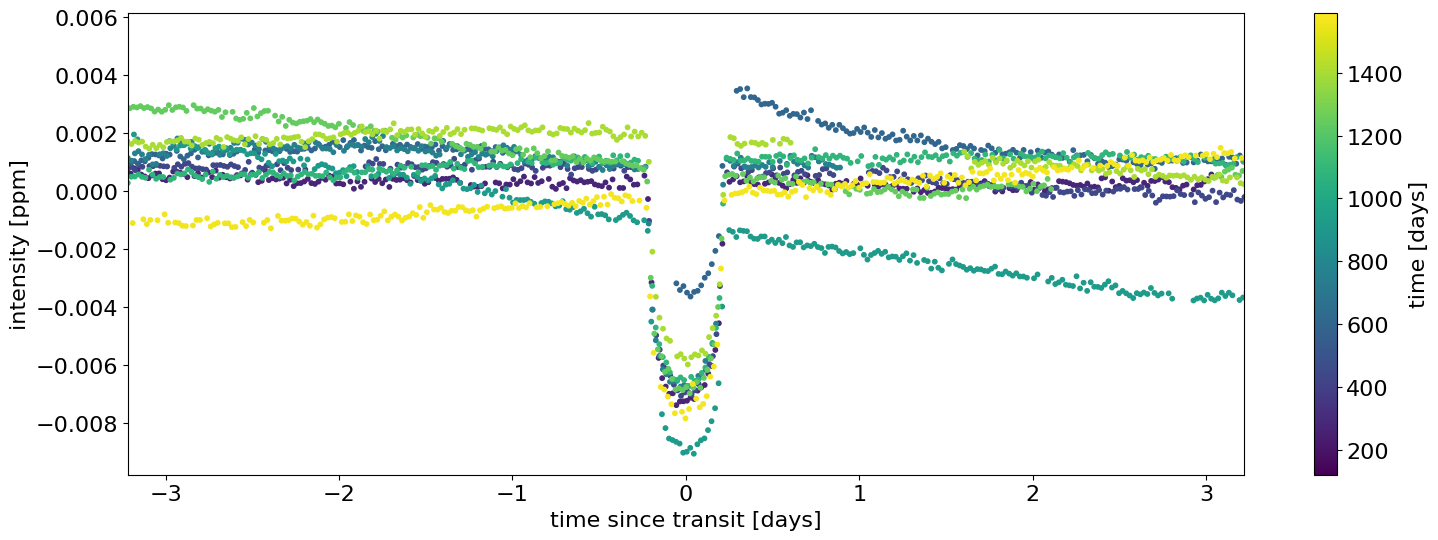

In [994]:
x, y, yerr = recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star)
plot_phase_fold_lc(x, y, period, t0s, 50)

In [995]:
# 0.01 days ~ .24 hours
# 11 points...as long as its not longer than transit time-scale (t_window << t_transit)
#(maybe do 2 step process (one on masked data and then one on phase folded in transit))
moving_median_data = moving_median(x, y, yerr, mask, 0.01, 4)

x = moving_median_data[0]
y = moving_median_data[1]
yerr = moving_median_data[2]
mask = moving_median_data[3]


moving_med = moving_median_data[5]

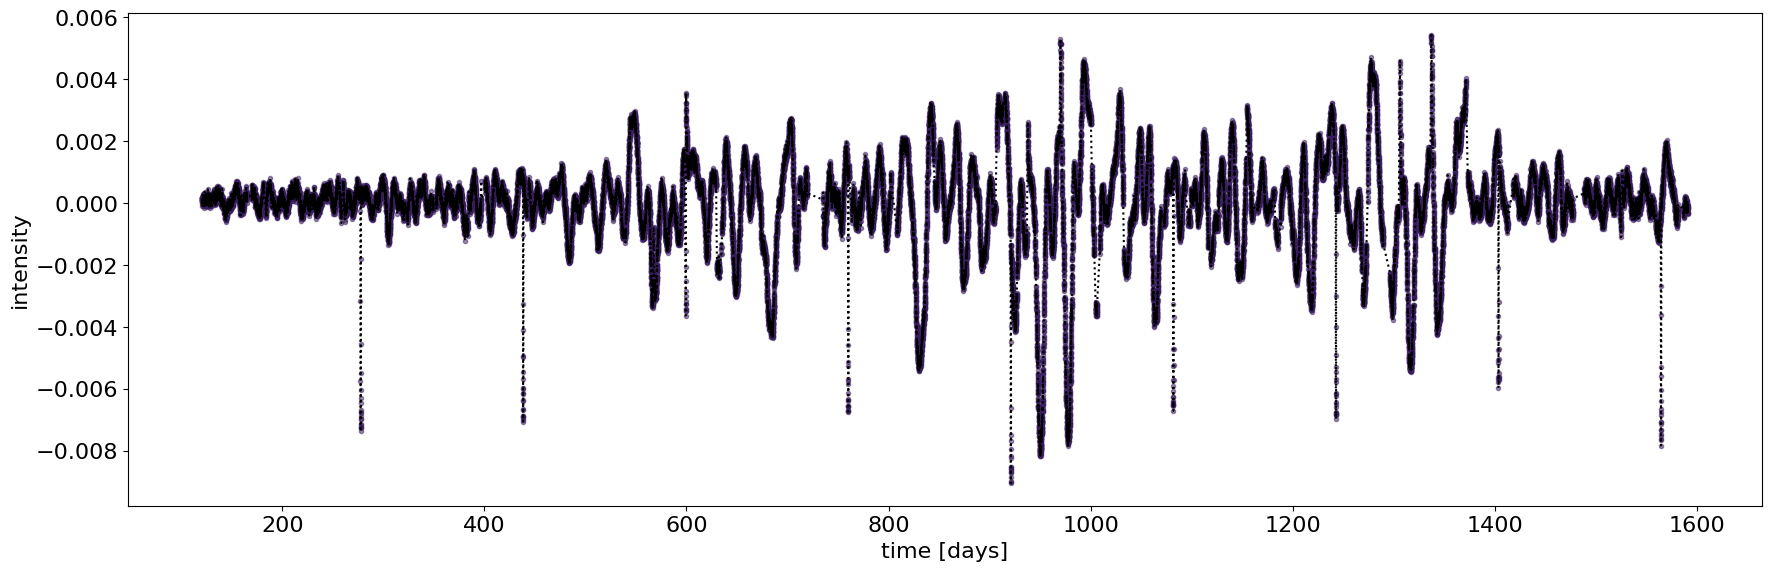

In [996]:
plot_outliers(moving_median_data)

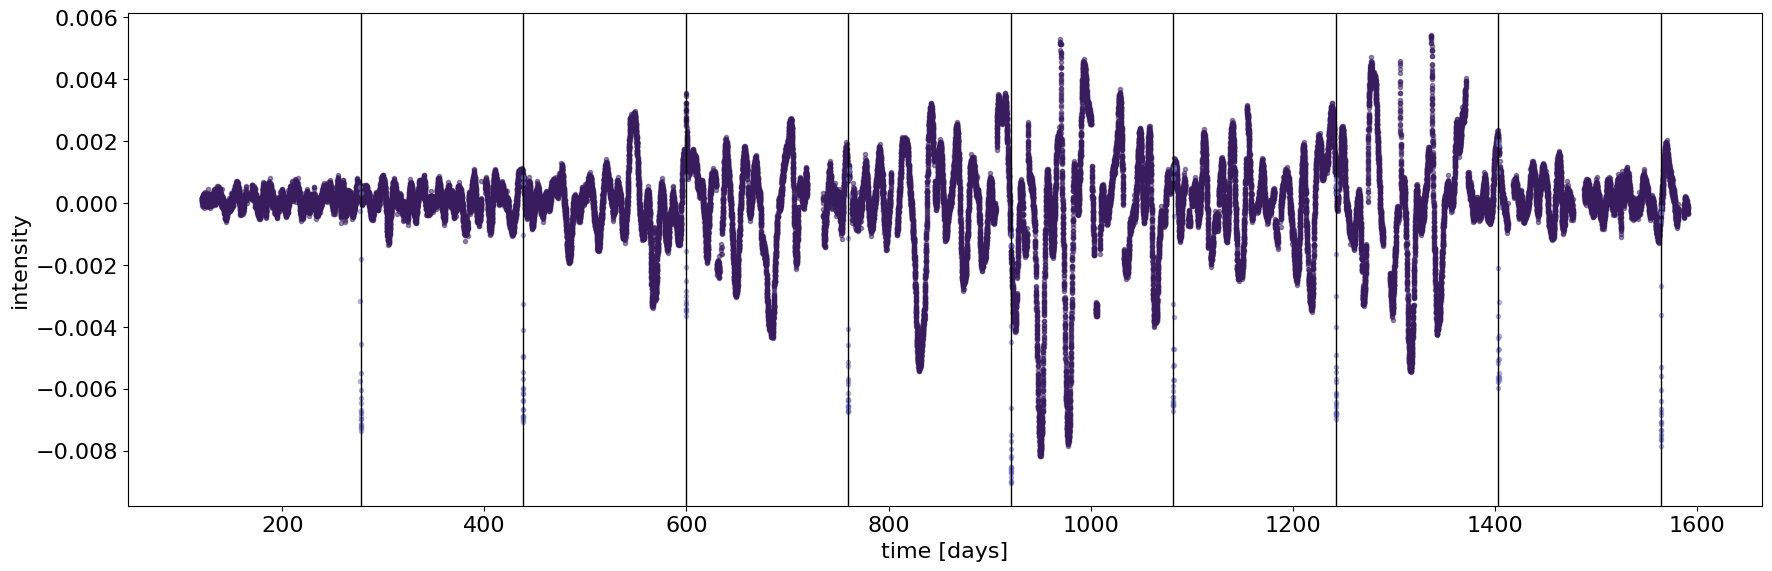

In [997]:
plot_lc(x[~mask], y[~mask], x[mask], y[mask], t0s)

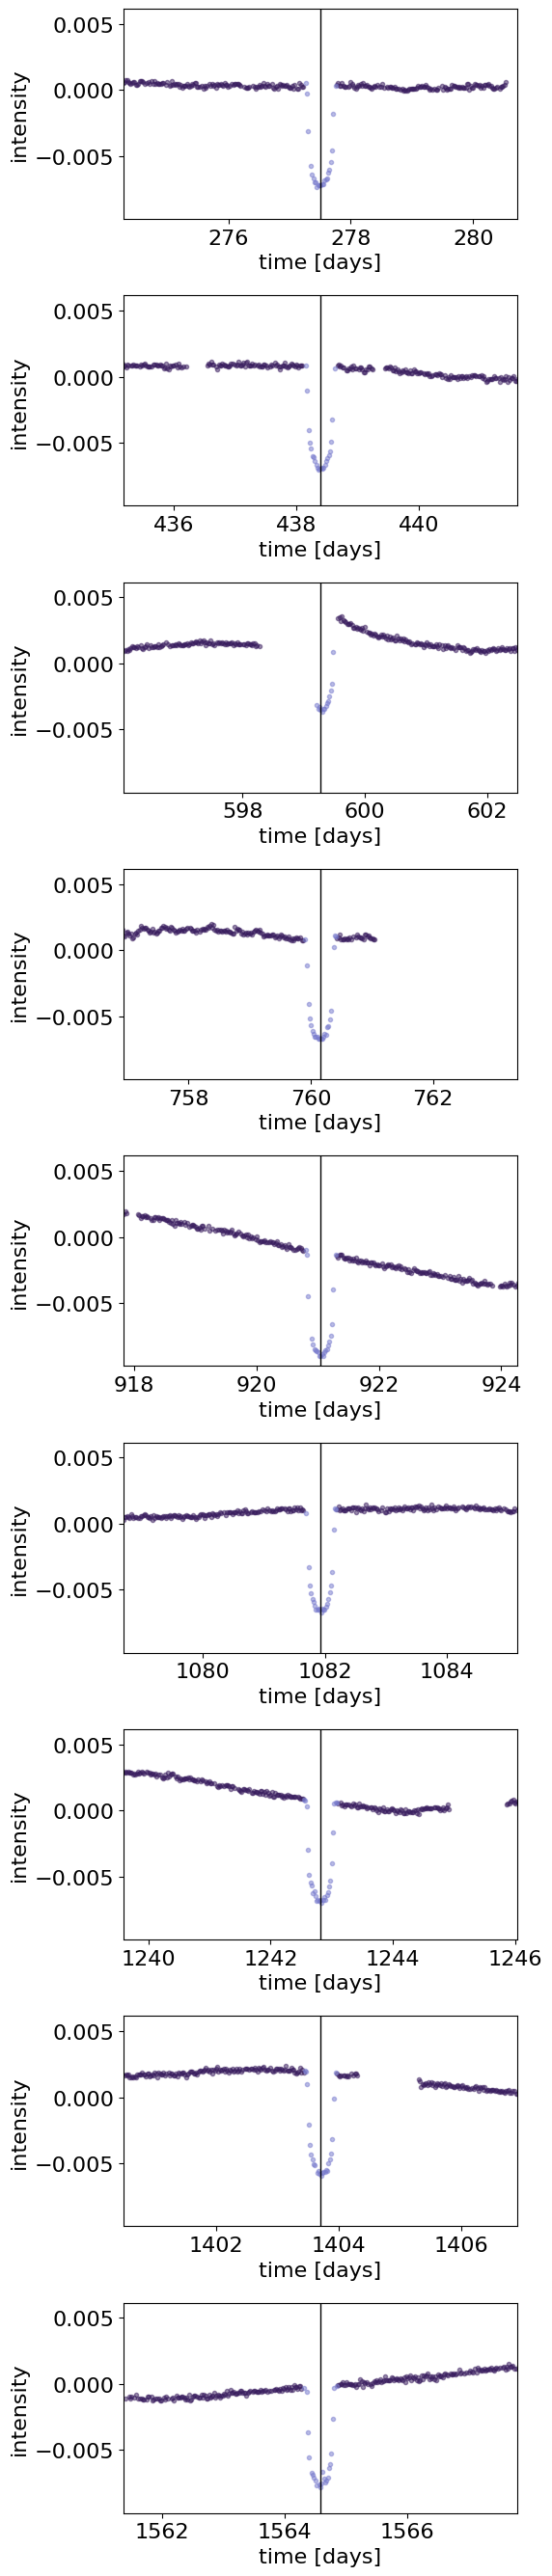

In [998]:
plot_individual_lc(x[~mask], y[~mask], x[mask], y[mask], t0s, 50, period)

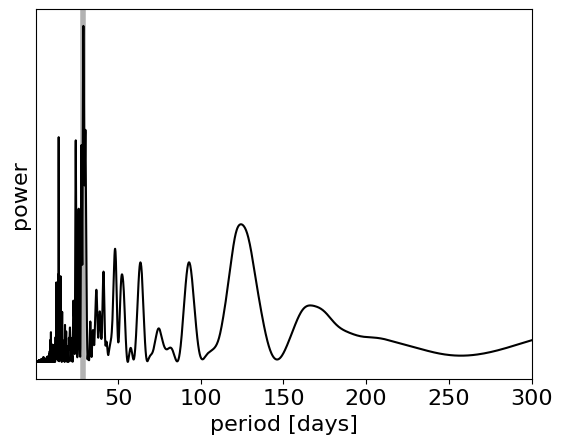

In [999]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    time_star, lc_star, max_peaks=1, min_period=0.1, max_period=300.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

In [1000]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(lc_err_star)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", testval=np.log(peak["period"]), sigma=10.0)
    period_star = pm.Deterministic("period_star", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period_star,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=time_star,
        diag=lc_err_star ** 2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    
    gp.marginal("gp", observed=lc_star)
    

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(lc_star, t=x))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 48834.46817253818 -> 453229.09401329374


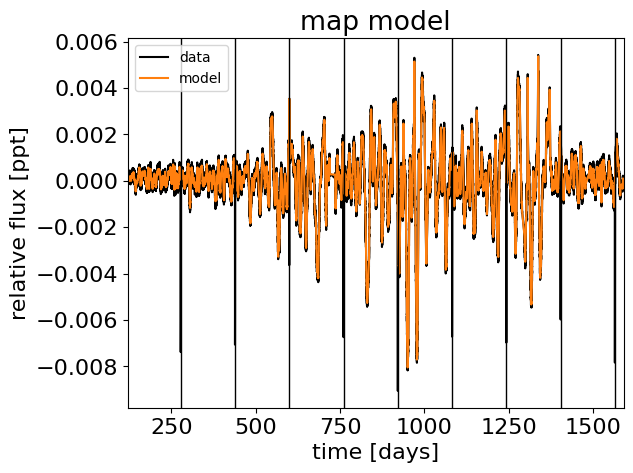

In [1001]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
[plt.axvline(_x, linewidth=1, color='k') for _x in t0s]

plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("map model")




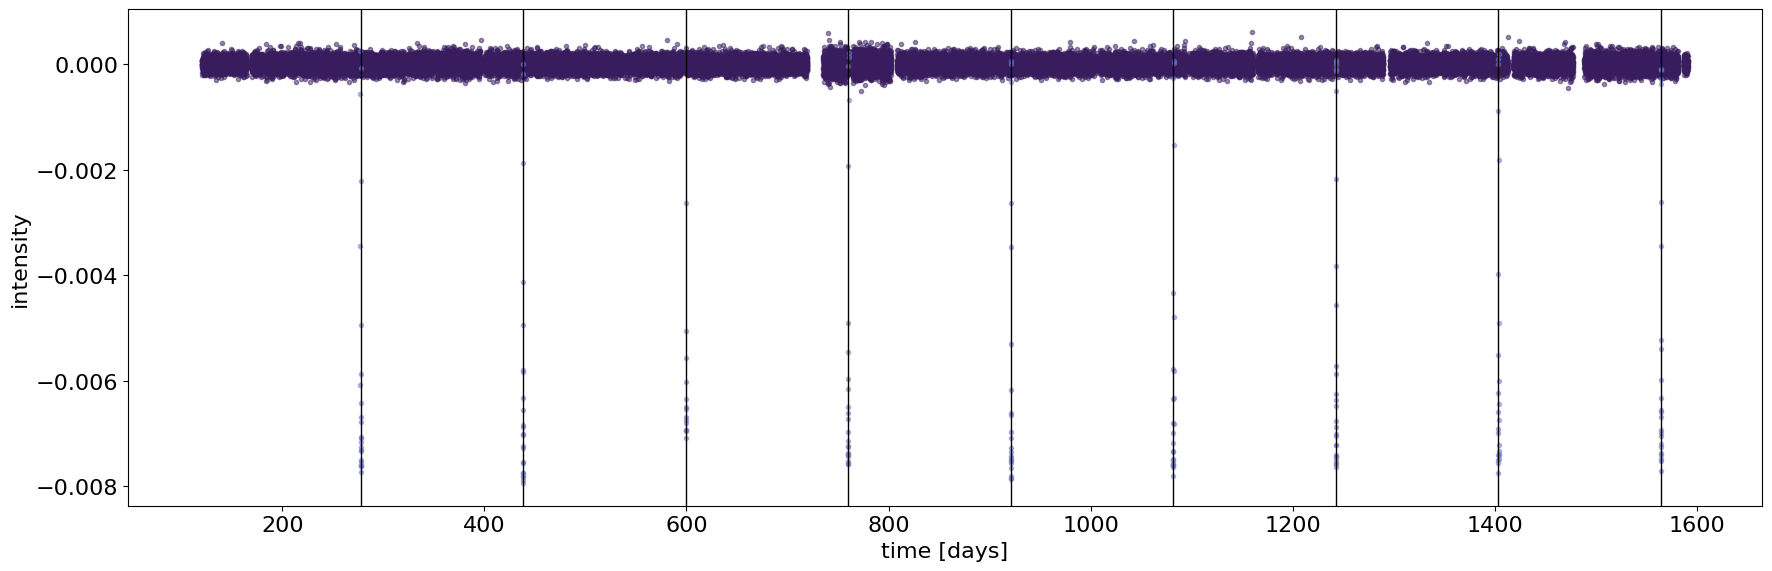

In [1002]:
plot_lc(x[~mask], (y[~mask]+1)/(map_soln["pred"][~mask]+1)-1, x[mask], (y[mask]+1)/(map_soln["pred"][mask]+1)-1, t0s)

In [1003]:
print(len(map_soln["pred"]))
print(len(lc_star))

60038
59834


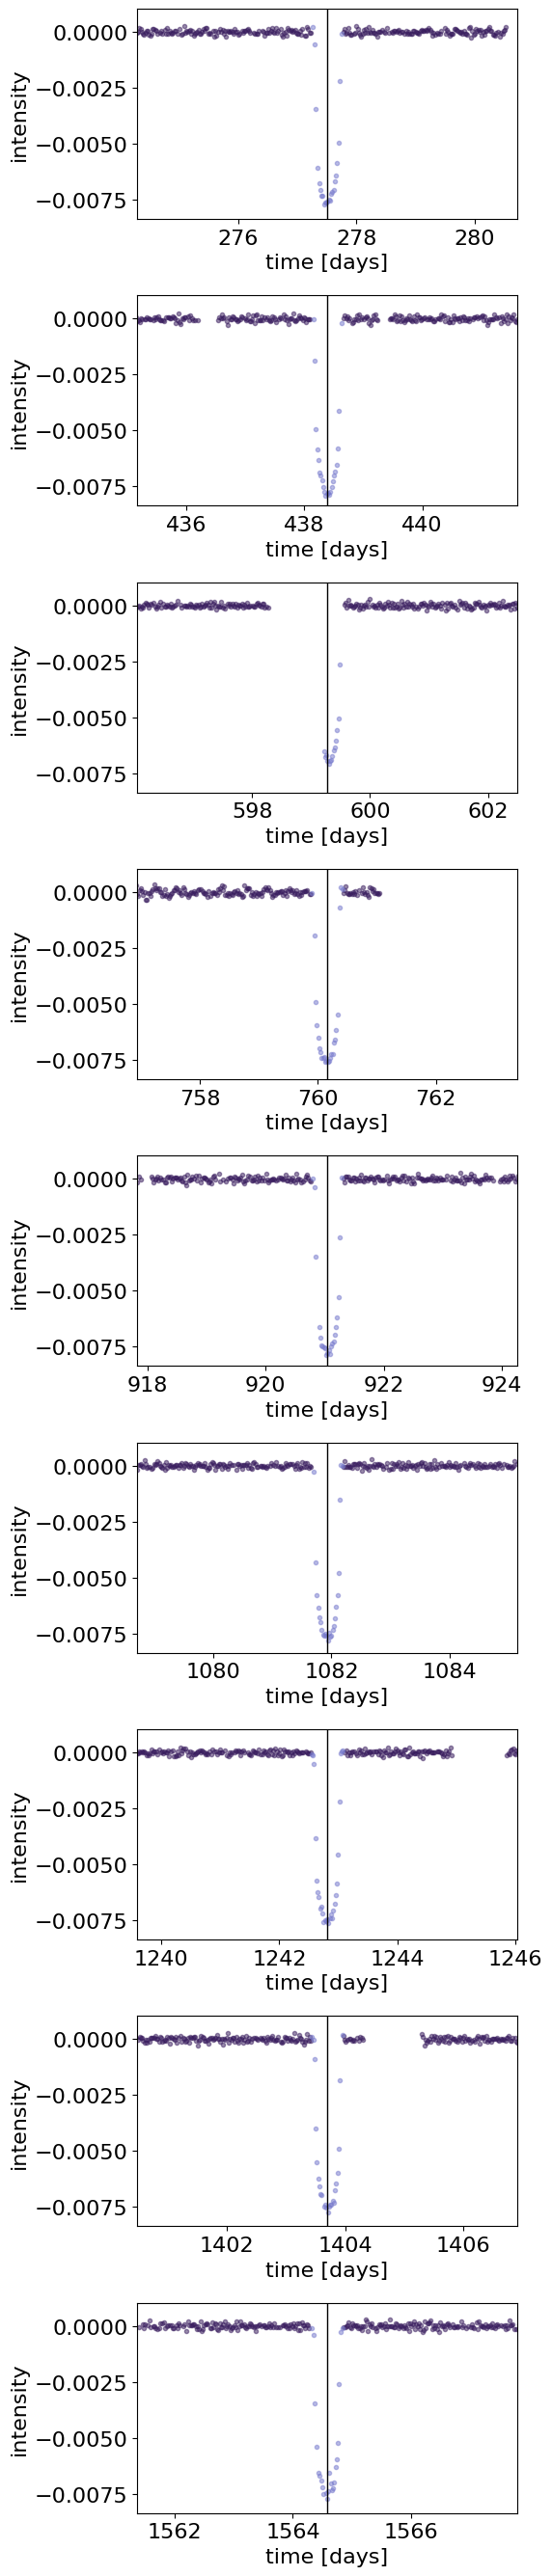

In [1004]:
plot_individual_lc(x[~mask], (y[~mask]+1)/(map_soln["pred"][~mask]+1)-1, x[mask], (y[mask]+1)/(map_soln["pred"][mask]+1)-1, t0s, 50, period)

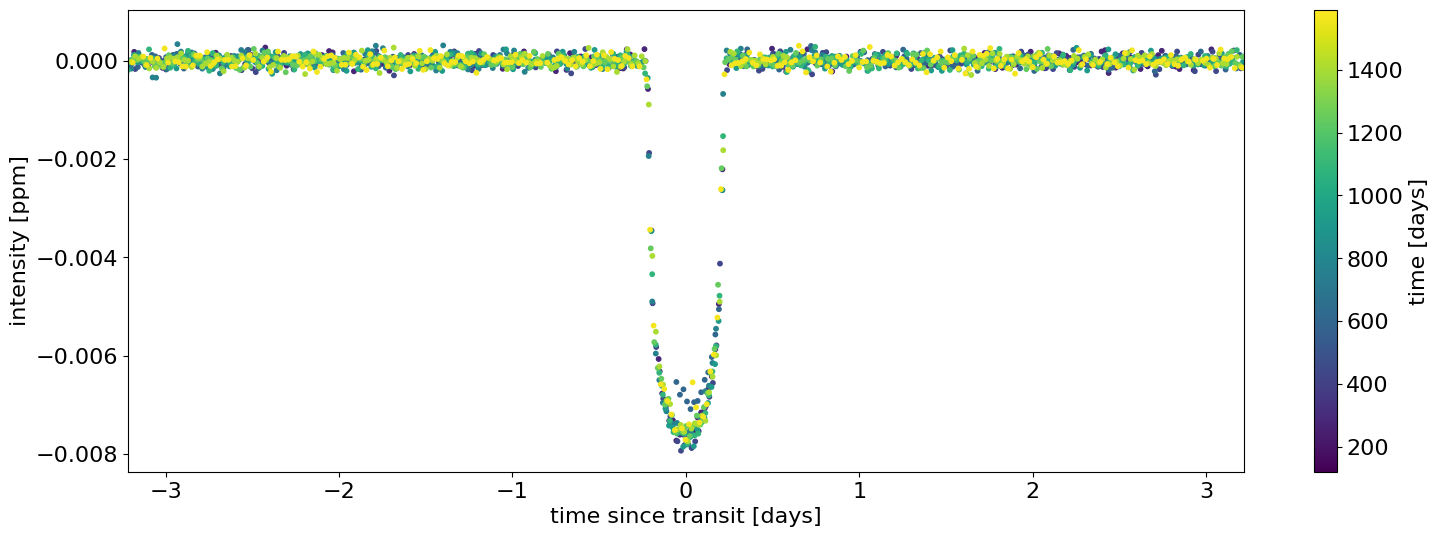

In [1005]:
y = (y+1)/(map_soln["pred"]+1)-1
plot_phase_fold_lc(x, y, period, t0s, 50)

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

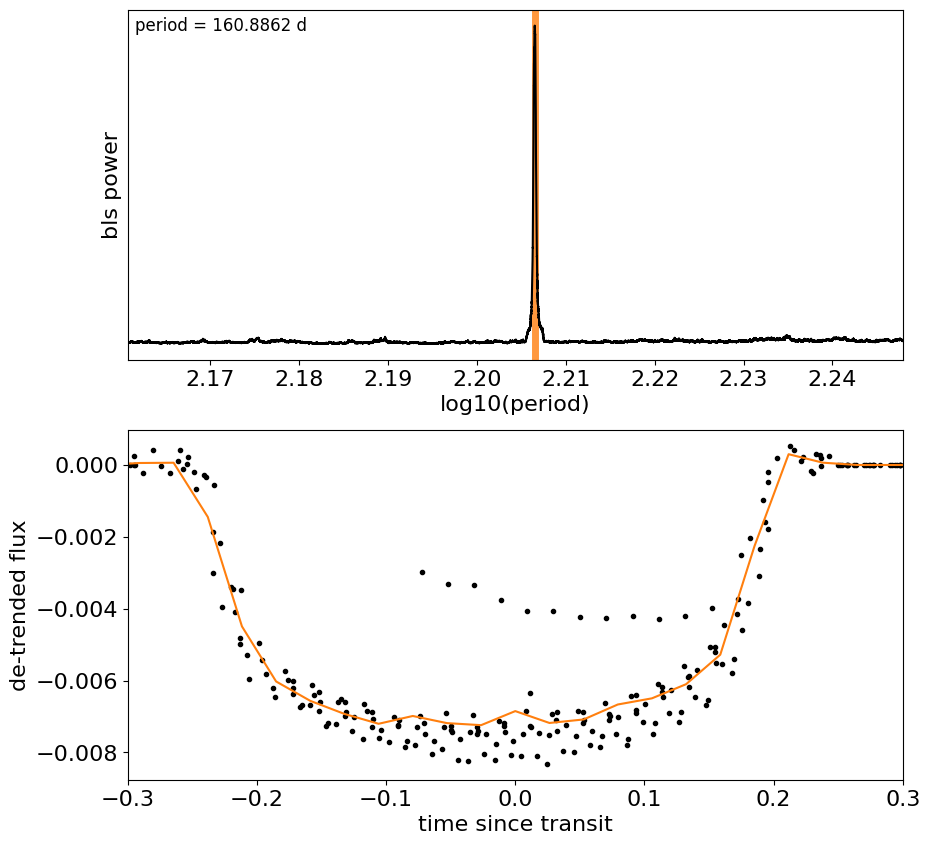

In [974]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(period[0]-.1*period[0]), np.log(period[0]+.1*period[0]), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux")
_ = ax.set_xlabel("time since transit")

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in {ref}`joint`.

In [975]:
texp = 2. / (60.0 * 24.0)


In [976]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=1)
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.ImpactParameter(
        "b", ror=r, shape=1, testval=0.5 * np.random.rand(1)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=1.0,
                shape=len(t0s),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(1):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=x, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)


    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln, vars=[r, b])
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 210488.3602034233 -> 212521.8064794572
optimizing logp for variables: [b, logr]


message: Desired error not necessarily achieved due to precision loss.
logp: 212521.8064794572 -> 487032.4017409252
optimizing logp for variables: [tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 487032.4017409252 -> 492033.01216266834
optimizing logp for variables: [tts_0, b, logr, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 492033.01216266834 -> 492178.5613513281


Here's how we plot the initial light curve model:

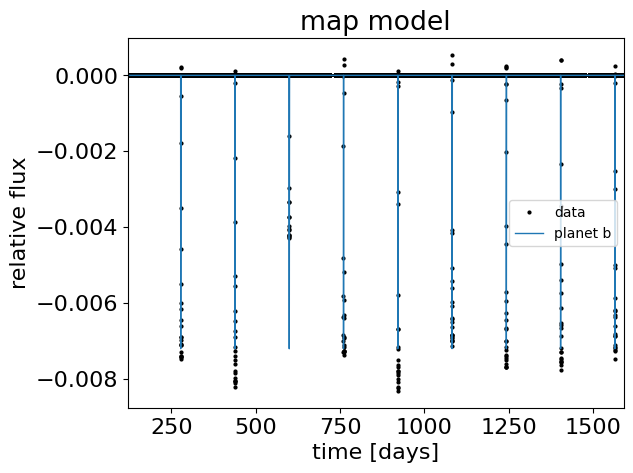

In [977]:
plt.plot(x, y, ".k", ms=4, label="data")
for i, l in enumerate("b"):
    plt.plot(
        x, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(x.min(), x.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

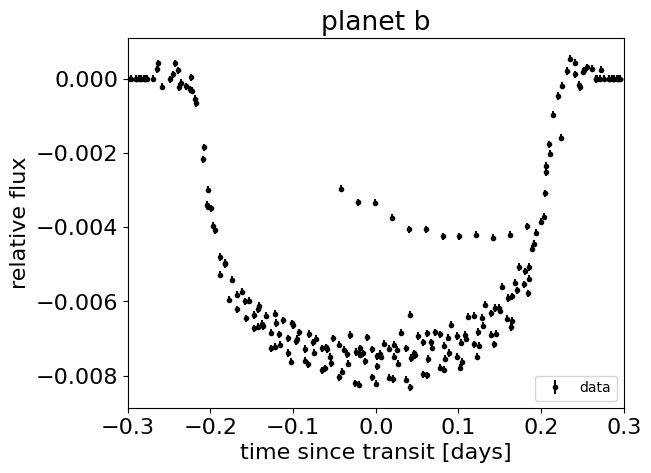

In [978]:
with model:
    t_warp = pmx.eval_in_model(orbit._warp_times(x), map_soln)

for n, letter in enumerate("b"):
    plt.figure()

    p = map_soln["period"][n]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [979]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tts_0, b, logr, u, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 159 seconds.


In [980]:
import arviz as az

az.summary(trace, var_names=["mean", "u", "r", "b", "tts_0", "period"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,-0.000,0.000,-0.000,0.000,0.0,0.0,2795.0,1545.0,1.00
u[0],0.420,0.015,0.391,0.448,0.0,0.0,2557.0,1218.0,1.00
u[1],0.059,0.025,0.012,0.105,0.0,0.0,2540.0,1437.0,1.00
r[0],0.078,0.000,0.078,0.078,0.0,0.0,2454.0,1571.0,1.00
b[0],0.006,0.005,0.000,0.014,0.0,0.0,1426.0,788.0,1.00
tts_0[0],277.506,0.000,277.505,277.506,0.0,0.0,2278.0,1615.0,1.00
tts_0[1],438.386,0.000,438.385,438.386,0.0,0.0,1995.0,1334.0,1.00
tts_0[2],599.261,0.000,599.260,599.262,0.0,0.0,2250.0,1358.0,1.00
tts_0[3],760.153,0.001,760.151,760.154,0.0,0.0,2227.0,1054.0,1.00
tts_0[4],921.048,0.000,921.047,921.049,0.0,0.0,2142.0,1656.0,1.00


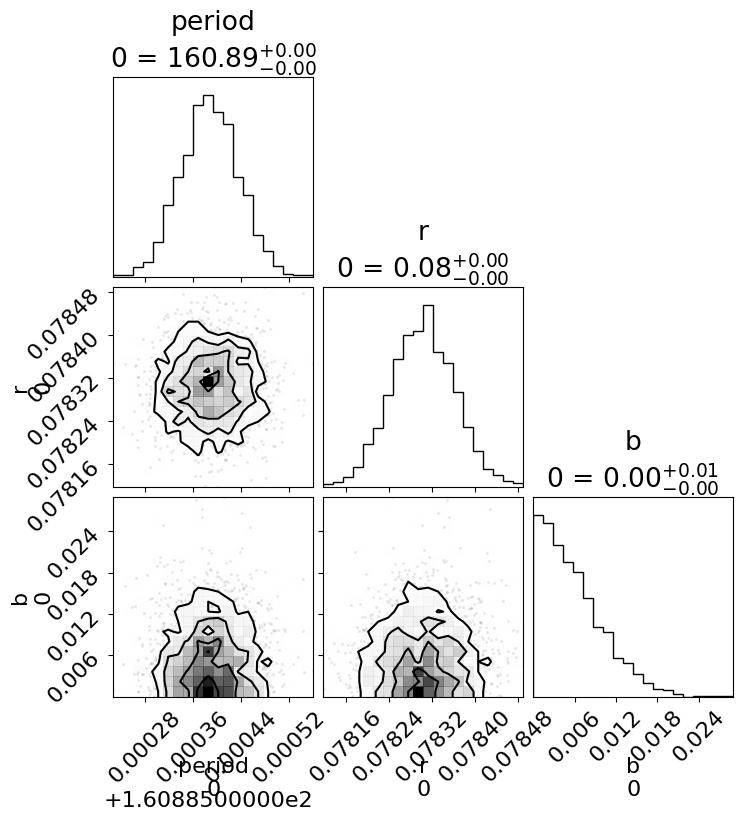

In [981]:
import corner

names = ["period", "r", "b"]


_ = corner.corner(
    trace,
    var_names=names,
    show_titles=True
)

In [982]:
tts_median = []
ttvs_median = []
P_median = np.quantile(trace.posterior["period"].values, 0.5)
t0_median = np.median(trace.posterior["t0"].values)

tts_err = []
ttvs_err = []
for ii in range(0, len(t0s)):
    tts = np.median(trace.posterior["tts_0"].values[:, :, ii])
    ttvs = 24.*60.*np.median(trace.posterior["ttvs_0"].values[:, :, ii])
    
    tts_median.append(tts)
    ttvs_median.append(ttvs)
    
    
    tts_quantile = [np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.16),
                    np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.84)]
    ttvs_quantile = [24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.16),
                     24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.84)]
    
    tts_err.append(np.array([
        tts - tts_quantile[0],
        tts_quantile[1] - tts
    ]))
    ttvs_err.append(np.array([
        ttvs - ttvs_quantile[0],
        ttvs_quantile[1] - ttvs
    ]))
    

tts_err = np.array(tts_err).T
ttvs_err = np.array(ttvs_err).T



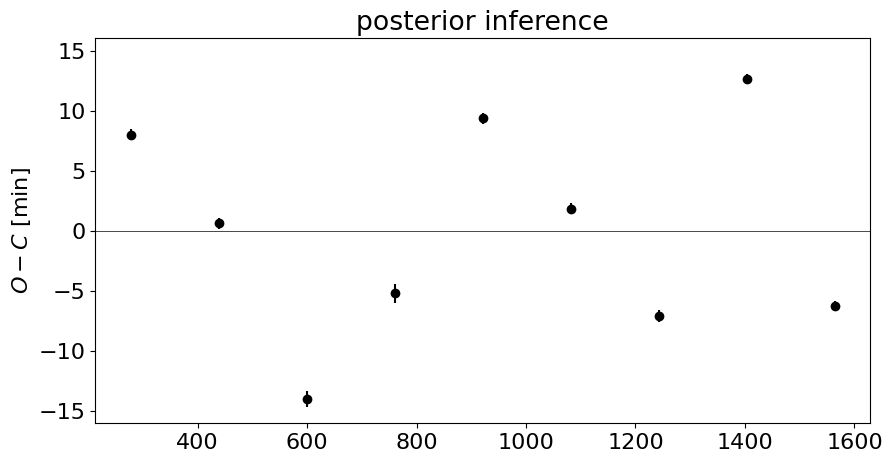

In [983]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

ax1.errorbar(tts_median, ttvs_median, xerr = tts_err, yerr = ttvs_err, ls = '', marker = 'o', color = 'k')
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")


_ = ax1.set_title("posterior inference")

1.1898377965553664
1.2010604121269353
-3.8865444662314985
-3.893991392251337
6.016705297297449
6.006493373206467
-8.096189112729917
-8.105464410300556
3.5133572638187616
3.5143440114188707
3.236805214037304
3.2415280746499775
-4.506241425988264
-4.5029567680103355
7.323987846793898
7.307924559318053
-4.762115483536036
-4.768624633306899

3.5735413670954586
3.992472643585643
4.830335196566011
5.2492664730561955
5.66819774954638
6.087129026200273
6.506060302526748
6.924991579180642


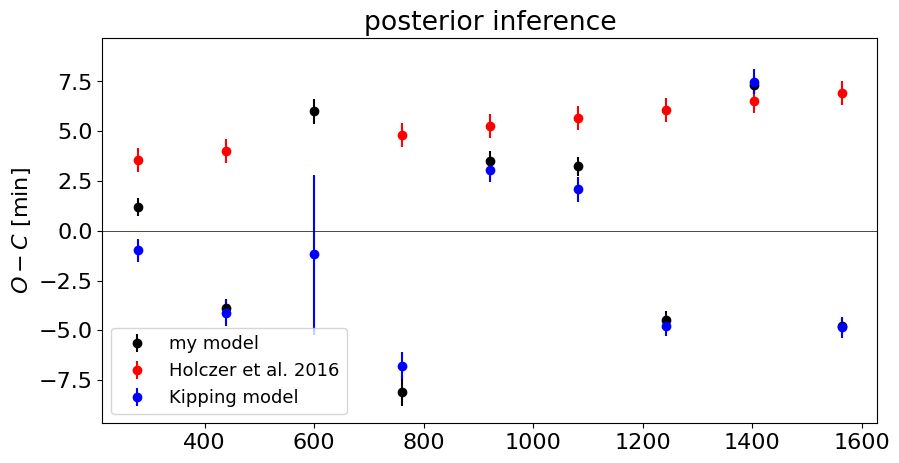

In [960]:
t_offset = 2454900 - 2454833 

time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))
    print(24. * 60. * (tts_median[ii]-time_model[ii]))
    print(ttvs_median[ii])
    
    
print('')
    

x_holczer = np.array([210.508782, 371.393408, 693.162660, 854.047286, 1014.931912, 1175.816538, 1336.701164, 1497.585790])
x_holczer += t_offset
y_holczer = []
epoch = 0
for time in x_holczer:
    if epoch == 2:
        epoch += 1
        
    print(24. * 60. * (time-time_model[epoch]))
    C = x_holczer[0]+(epoch*P_median)
        

    
    #y_holczer.append((24. * 60. * (time-C))+3.6400)
    y_holczer.append(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    

#y_holczer = np.array([3.6400, -3.6800, -6.0300, 4.5100, 3.0200, -4.2100, 8.1400, -5.3800])
yerr_holczer = np.array([6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01])

x_kipping = np.array([55110.505627155893, 55271.387764127088, 55432.274166387979,
                      55593.154601972172, 55754.045764114046, 55914.929417273248, 
                      56075.808992459257, 56236.701851571495, 56397.577613172602])
yerr_kipping = np.array([
    [0.000402962774, 0.000399917204],
    [0.000440256757, 0.000441709722],
    [0.002814652733, 0.002745562269],
    [0.00046894051, 0.000469475679],
    [0.000409040716, 0.000403825223],
    [0.000424959595, 0.000417035772],
    [0.000362309329, 0.000367076056],
    [0.000423798963, 0.000430076718],
    [0.000367674438, 0.000366104934]]).T
yerr_kipping = 24.*60.*yerr_kipping


x_kipping -= 54833 
y_kipping = []
epoch = 0
for time in x_kipping:
    C = x_kipping[0]+(epoch*P_median)
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    
    #y_kipping.append((24. * 60. * (time-C))+1.087096278)
    epoch+=1
    
'''    
# for TTVs comparison, read in times and then subtract out ephemeris information
0	55110.505627155893	0.000402962774	0.000399917204	1.087096278	0.580266395	0.575880774
1	55271.387764127088	0.000440256757	0.000441709722	-2.265761699	0.633969731	0.636062
2	55432.274166387979	0.002814652733	0.002745562269	0.523397485	4.053099936	3.953609668
3	55593.154601972172	0.00046894051	0.000469475679	-5.279457775	0.675274335	0.676044978
4	55754.045764114046	0.000409040716	0.000403825223	4.363930026	0.589018632	0.581508321
5	55914.929417273248	0.000424959595	0.000417035772	3.194382779	0.611941817	0.600531511
6	56075.808992459257	0.000362309329	0.000367076056	-3.847445866	0.521725434	0.528589521
7	56236.701851571495	0.000423798963	0.000430076718	8.23957926	0.610270507	0.619310473
8	56397.577613172602	0.000367674438	0.000366104934	-4.293811645	0.529451191	0.527191105
'''



fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = ttvs_err, ls = '', marker = 'o', color = 'k', label = "my model")
ax1.errorbar(x_holczer, y_holczer, yerr = yerr_holczer, ls = '', marker = 'o', color = 'r', label = "Holczer et al. 2016")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 13, loc=3)
_ = ax1.set_title("posterior inference")             